In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler

# Load the datasets
train_df = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test_df = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])


In [2]:
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


<Axes: >

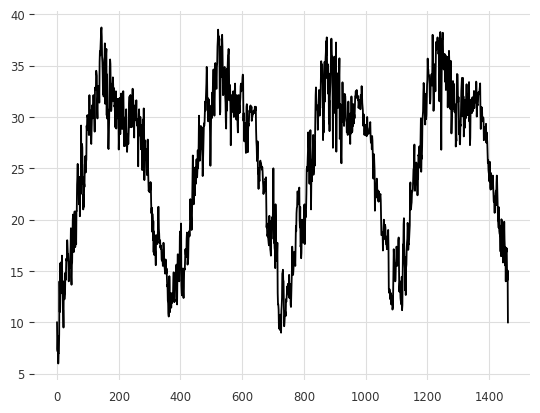

In [3]:
train_df.meantemp.plot()

In [4]:
# Convert to TimeSeries object
temperature_series = TimeSeries.from_dataframe(train_df, 'date', 'meantemp')
#scaling the meantemp data
scaler_ts = Scaler()
temperature_series_transformed = scaler_ts.fit_transform(temperature_series)
# Splitting the data into training and validation sets (80% train, 20% validation)
train_ts, val_ts = temperature_series_transformed.split_after(0.8)

In [5]:
temperature_series_transformed.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[0.12227074]],

       [[0.04279476]],

       [[0.0356623 ]],

       [[0.08151383]],

       [[0.        ]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'meantemp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Part 1: DeepAR model

In [6]:
#Building DeepAR Model:
from darts.models import RNNModel, TCNModel, NBEATSModel, TransformerModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
parameters = {
    'model': ['LSTM'],
    'hidden_dim': [10, 20, 30, 40, 50],
    'n_rnn_layers': [1, 2, 3, 4, 5],
    'dropout': [0.0, 0.2, 0.7],  # Adjust dropout accordingly
    'n_epochs': [10],
    'input_chunk_length': [6, 12, 18, 24]  # Adjust the input_chunk_length accordingly
}
best_model, best_params, best_metric = RNNModel.gridsearch(
    parameters,
    train_ts,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=8,
)


  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Print the evaluation metric for the best model
print("Best Metric:", best_metric)

Best Hyperparameters: {'model': 'LSTM', 'hidden_dim': 50, 'n_rnn_layers': 2, 'dropout': 0.0, 'n_epochs': 10, 'input_chunk_length': 18}
Best Metric: 16.96381300314402


In [8]:
# Update the 'n_epochs' key in the best_params dictionary
best_params['n_epochs'] = 100

#Create an instance of the best model with the best hyperparameters
best_BasicDeepAR_model = RNNModel(**best_params)

# Train the best model on the training data
best_model.fit(train_ts)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 31.0 K
4 | V             | Linear           | 51    
---------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=50, n_rnn_layers=2, dropout=0.0, training_length=24, n_epochs=10, input_chunk_length=18)

In [9]:
from darts.metrics import mae, mape
import numpy as np
# Make predictions on the validation set
pred_series = best_model.predict(len(val_ts))

# Calculate MAE and MAPE
mae_val = mae(val_ts, pred_series)

print(f'MAE on validation data: {mae_val:.4f}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

MAE on validation data: 0.1771


In [10]:
train_ts.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[0.12227074]],

       [[0.04279476]],

       [[0.0356623 ]],

       [[0.08151383]],

       [[0.        ]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'meantemp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [11]:
# Function to determine the season based on the month
def get_season(ts, month):
    if month in [3, 4, 5]:
        return np.float32(0)
    elif month in [6, 7, 8]:
        return np.float32(1)
    elif month in [9, 10, 11]:
        return np.float32(2)
    else:
        return np.float32(3)

month_feature = datetime_attribute_timeseries(temperature_series, attribute='month')
vectorized_get_season = np.vectorize(get_season)
month_feature.map(vectorized_get_season)

# Use get_dummies to one-hot encode the month_feature
season_feature_encoded = pd.get_dummies(month_feature.pd_series(), dtype=np.float32)
# Convert the one-hot encoded DataFrame back to TimeSeries
season_feature_encoded_ts = TimeSeries.from_dataframe(season_feature_encoded, freq='D')

train_future_covariates = datetime_attribute_timeseries(temperature_series, attribute='month', one_hot=True)

concatenated_covariates = train_future_covariates.stack(season_feature_encoded_ts)

# Scale the concatenated features if needed
scaler = Scaler()
concatenated_covariates_scaled = scaler.fit_transform(concatenated_covariates)

# Re-split into training and validation sets
train_future_covariates, val_future_covariates = concatenated_covariates_scaled.split_after(0.8)


In [12]:
# Train the model with the corrected future covariates
model_RNNwithCoV_1 = RNNModel(**best_params)
model_RNNwithCoV_1.fit(train_ts, future_covariates=train_future_covariates, verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 35.8 K
4 | V             | Linear           | 51    
---------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.143     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=50, n_rnn_layers=2, dropout=0.0, training_length=24, n_epochs=100, input_chunk_length=18)

both month and season are future covariates because they both are same in the future and repeat their pattern. so they help with our prediction and are recurring patterns, thats why i chose them as future covariates.

In [15]:
#streching the covariates enough into the past
train_region = train_future_covariates[pd.Timestamp("2016-02-26 00:00:00") : pd.Timestamp("2016-03-14 00:00:00")]
val_future_covariates = train_region.append(val_future_covariates)
# Predict with the corrected future covariates
pred_val_cov = model_RNNwithCoV_1.predict(len(val_ts), future_covariates=val_future_covariates)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [16]:
# Calculate MAE with covariates
mae_cov = mean_absolute_error(val_ts.univariate_values(), pred_val_cov.univariate_values())
print(f'MAE on validation data with covariates: {mae_cov}')

MAE on validation data with covariates: 0.07974285456174764


the mae is halfed now

In [17]:
# Adding new past covariates to the dataset
past_covariates_columns = ['humidity', 'wind_speed', 'meanpressure']
train_past_covariates = train_df.set_index('date')[past_covariates_columns]

# Converting to TimeSeries and scaling
train_past_covariates_ts = TimeSeries.from_dataframe(train_past_covariates)
scaler_past_cov = Scaler()
train_past_covariates_scaled = scaler_past_cov.fit_transform(train_past_covariates_ts)

# Splitting the past covariates into training and validation sets
train_past_covariates_scaled, val_past_covariates_scaled = train_past_covariates_scaled.split_after(0.8)

In [28]:
val_past_covariates_scaled

<TimeSeries (DataArray) (date: 293, component: 3, sample: 1)>
array([[[0.52563256],
        [0.20480025],
        [0.13249917]],

       [[0.46575908],
        [0.25772738],
        [0.13223179]],

       [[0.42605198],
        [0.16209735],
        [0.13192264]],

       [[0.55239274],
        [0.15898863],
        [0.13184128]],

       [[0.55940594],
        [0.0847601 ],
        [0.13176341]],

...

       [[0.63086526],
        [0.08403188],
        [0.1325901 ]],

       [[0.85973597],
        [0.14211274],
        [0.13276447]],

       [[0.88063806],
        [0.14842886],
        [0.13289464]],

       [[0.84983498],
        [0.17349597],
        [0.13265971]],

       [[1.        ],
        [0.        ],
        [0.1326467 ]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-03-15 2016-03-16 ... 2017-01-01
  * component  (component) object 'humidity' 'wind_speed' 'meanpressure'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [29]:
# Concatenate past and future covariates into a single TimeSeries and also streching it enough into the past
train_covariates = train_past_covariates_scaled.stack(train_future_covariates)
val_region = train_past_covariates_scaled[pd.Timestamp("2016-02-26 00:00:00") : pd.Timestamp("2016-03-14 00:00:00")]
val_past_covariates_scaled = val_region.append(val_past_covariates_scaled)
val_covariates = val_past_covariates_scaled.stack(val_future_covariates)

In [32]:
# --- Model Training with Both Past and Future Covariates ---
parameters['n_epochs']= [10]
best_model_cov, best_params_cov, best_metric_cov = RNNModel.gridsearch(
    parameters=parameters,
    series=train_ts,
    future_covariates=train_covariates,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

unlike season month and day, hummidity and... are reliant on real time data that we cant have, but they have great historical influence on our target data.

In [34]:
# Update the 'n_epochs' key in the best_params dictionary
best_params_cov['n_epochs'] = 100

#Create an instance of the best model with the best hyperparameters
best_model_cov_all = RNNModel(**best_params_cov)

# Train the best model on the training data
best_model_cov_all.fit(series = train_ts, future_covariates=train_covariates, verbose = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 29.5 K
4 | V             | Linear           | 31    
---------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)


Training: |                                                                                     | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=4, dropout=0.7, training_length=24, n_epochs=100, input_chunk_length=18)

In [35]:
#Evaluate Model with all the Covariates:
# Make predictions on the validation set with covariates
pred_val_cov_all = best_model_cov_all.predict(len(val_ts), future_covariates = val_covariates)

# Calculate MAE with covariates
mae_cov_all = mean_absolute_error(val_ts.univariate_values(), pred_val_cov_all.univariate_values())
print(f'MAE on validation data with covariates: {mae_cov_all}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

MAE on validation data with covariates: 0.07051171032294203


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

MAE on validation data: 0.0581


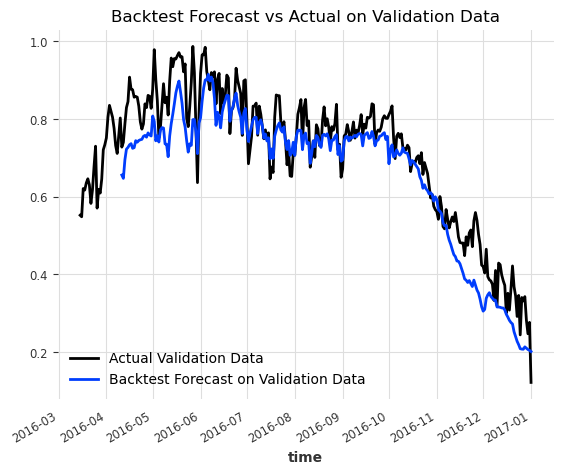

In [37]:
# Perform backtesting on the validation set
backtest_predictions = best_model_cov_all.historical_forecasts(
    series=val_ts,
    future_covariates=val_covariates,
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True
)

# Calculate MAE on the validation set
mae_backtest = mae(val_ts, backtest_predictions)
print(f'MAE on validation data: {mae_backtest:.4f}')

# Plotting the results
val_ts.plot(label='Actual Validation Data')
backtest_predictions.plot(label='Backtest Forecast on Validation Data')
plt.title("Backtest Forecast vs Actual on Validation Data")
plt.legend()
plt.show()

 these two terms can sometimes be used to describe the same process of evaluating a model against historical data. However, the key distinction lies in the broader application context (e.g., financial strategy testing vs. general time series forecasting) and the specific focus of the evaluation (strategy viability vs. model accuracy).

## Part 2: NBeats Model

In [42]:
nbeats_parameters = {
    'input_chunk_length': [10, 20],
    'output_chunk_length': [5, 10],
    'num_blocks': [1, 3, 5],
    'num_stacks': [1, 2],
    'num_layers': [2, 4],
    'layer_widths': [128, 256],
    'dropout': [0.0, 0.2],
    'n_epochs': [10],
}

In [43]:
best_model_no_cov, best_params_no_cov, best_metric_no_cov = NBEATSModel.gridsearch(
    parameters=nbeats_parameters,
    series=train_ts,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=5
)


  0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
best_params_no_cov['n_epochs']=100
best_model_no_cov = NBEATSModel(**best_params_no_cov)
best_model_no_cov.fit(train_ts)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 356 K 
---------------------------------------------------
355 K     Trainable params
1.3 K     Non-trainable params
356 K     Total params
1.426     Total estimated model params size (MB)


Training: |                                                                                     | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=1, num_blocks=5, num_layers=2, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=10, output_chunk_length=10, n_epochs=100)

In [45]:
# Use the best hyperparameters from Scenario 1 (No Covariates)
best_params_scenario1 = best_params_no_cov

# Create a new N-BEATS model with these parameters for Scenario 2 (Future Covariates)
model_nbeats_future_cov = NBEATSModel(**best_params_scenario1)
model_nbeats_future_cov.fit(train_ts, past_covariates=train_future_covariates)

# Forecasting on validation set for Scenario 2
forecast_future_cov = model_nbeats_future_cov.predict(len(val_ts), past_covariates=val_future_covariates)
mae_future_cov = mae(val_ts, forecast_future_cov)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 678 K 
---------------------------------------------------
675 K     Trainable params
2.8 K     Non-trainable params
678 K     Total params
2.712     Total estimated model params size (MB)


Training: |                                                                                     | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=100` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

In [46]:
best_model_both_cov, best_params_both_cov, best_metric_both_cov = NBEATSModel.gridsearch(
    parameters=nbeats_parameters,
    series=train_ts,
    past_covariates= train_covariates,
    forecast_horizon=10,
    verbose=True,
    n_jobs=-1,
    n_random_samples=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
best_params_both_cov['n_epochs']=100
best_model_both_cov = NBEATSModel(**best_params_both_cov)
best_model_both_cov.fit(train_ts, past_covariates= train_covariates)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 562 K 
---------------------------------------------------
558 K     Trainable params
4.0 K     Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)


Training: |                                                                                     | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=2, num_blocks=3, num_layers=2, layer_widths=128, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=20, output_chunk_length=5, n_epochs=100)

In [49]:
# making the covariates strech enough into the past for our both_cov model
val_region = train_covariates[pd.Timestamp("2016-02-24 00:00:00") : pd.Timestamp("2016-02-25 00:00:00")]
val_covariates_all = val_region.append(val_covariates)

In [50]:
forecast_no_cov = best_model_no_cov.predict(len(val_ts))
mae_no_cov = mae(val_ts, forecast_no_cov)
forecast_future_cov = model_nbeats_future_cov.predict(len(val_ts), past_covariates=val_future_covariates)
mae_future_cov = mae(val_ts, forecast_future_cov)
forecast_both_cov = best_model_both_cov.predict(len(val_ts), past_covariates=val_covariates_all)
mae_both_cov = mae(val_ts, forecast_both_cov)

print("MAE No Covariates:", mae_no_cov)
print("MAE Future Covariates:", mae_future_cov)
print("MAE Both Past and Future Covariates:", mae_both_cov)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                   | 0/? [00:00<?…

MAE No Covariates: 0.36389669274229725
MAE Future Covariates: 0.0820578343738724
MAE Both Past and Future Covariates: 0.06876909578028764


In [53]:

# Define the data
data = {
    '-': [None, 0.1771, 0.36389669274229725],
    'Month and Season': [None, 0.07974285456174764, 0.0820578343738724],
    'Mean Pressure and Humidity and Wind Speed': [None, 0.07051171032294203, 0.06876909578028764]
}

# Create the DataFrame
end_table = pd.DataFrame(data, index=['Model/Covariates', 'DeepAR', 'N-BEATS'])

# Display the DataFrame
end_table


,-,Month and Season,Mean Pressure and Humidity and Wind Speed
Model/Covariates,NaN,NaN,NaN
DeepAR,0.177100,0.079743,0.070512
N-BEATS,0.363897,0.082058,0.068769
